In [1]:
import os
import sys
os.chdir("/Users/DanPfeiffer/Documents/code/data-collector/src")
sys.path.append(os.getcwd())
import pandas as pd
import importlib
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, ParameterSampler
import itertools

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
random_state=54

In [4]:
file_list = os.listdir('../data/transformed')
file_list.sort()
file_list

['.DS_Store',
 '16_games_exp_weighted_mean_decay0.6999999999999997_training.csv',
 '16_games_exp_weighted_mean_decay0.7199999999999998_training.csv',
 '16_games_exp_weighted_mean_decay0.7399999999999999_training.csv',
 '16_games_exp_weighted_mean_decay0.7599999999999999_training.csv',
 '16_games_exp_weighted_mean_decay0.7799999999999999_training.csv',
 '16_games_exp_weighted_mean_decay0.7999999999999999_training.csv',
 '16_games_exp_weighted_mean_decay0.8199999999999998_training.csv',
 '16_games_exp_weighted_mean_decay0.82_training.csv',
 '16_games_exp_weighted_mean_decay0.8399999999999999_training.csv',
 '16_games_exp_weighted_mean_decay0.8599999999999999_training.csv',
 '16_games_exp_weighted_mean_decay0.8799999999999999_training.csv',
 '16_games_exp_weighted_mean_decay0.88_training.csv',
 '16_games_exp_weighted_mean_decay0.8999999999999999_training.csv',
 '16_games_exp_weighted_mean_decay0.9199999999999999_training.csv',
 '16_games_exp_weighted_mean_decay0.94_training.csv',
 '16_gam

In [5]:
skip_files = ['training.csv', 'box_scores.csv', '.DS_Store']
read_files = [file for file in file_list if file not in skip_files]
experiment_names = [file.replace("_training.csv", "") for file in read_files]
files_to_exp_names = dict(zip(read_files, experiment_names))
print(files_to_exp_names)

{'16_games_exp_weighted_mean_decay0.6999999999999997_training.csv': '16_games_exp_weighted_mean_decay0.6999999999999997', '16_games_exp_weighted_mean_decay0.7199999999999998_training.csv': '16_games_exp_weighted_mean_decay0.7199999999999998', '16_games_exp_weighted_mean_decay0.7399999999999999_training.csv': '16_games_exp_weighted_mean_decay0.7399999999999999', '16_games_exp_weighted_mean_decay0.7599999999999999_training.csv': '16_games_exp_weighted_mean_decay0.7599999999999999', '16_games_exp_weighted_mean_decay0.7799999999999999_training.csv': '16_games_exp_weighted_mean_decay0.7799999999999999', '16_games_exp_weighted_mean_decay0.7999999999999999_training.csv': '16_games_exp_weighted_mean_decay0.7999999999999999', '16_games_exp_weighted_mean_decay0.8199999999999998_training.csv': '16_games_exp_weighted_mean_decay0.8199999999999998', '16_games_exp_weighted_mean_decay0.82_training.csv': '16_games_exp_weighted_mean_decay0.82', '16_games_exp_weighted_mean_decay0.8399999999999999_trainin

### Test Agg Method

Loop through all the training data experiments and see which has the best performance

In [8]:
train_features = [
    'game_datetime',
    'home_offense_special_teams_net_punt_ypa',
    'offense_special_teams_net_punt_ypa_all_matchup_differential',
    'offense_special_teams_gross_punt_ypa_matchup_differential',
    'offense_special_teams_fg_made_pcnt_matchup_differential',
    'road_defense_passing_attempts',
    'road_defense_passing_completion_pcnt',
    'road_defense_passing_ypa',
    'road_defense_passing_ypc',
    'road_defense_passing_1st_downs',
    'road_defense_passing_td_pcnt',
    'road_defense_passing_pass_rtg',
    'road_defense_passing_sack_pcnt',
    'road_defense_passing_sacks',
    'road_defense_passing_1st_down_pcnt',
    'road_defense_rushing_attempts',
    'road_defense_rushing_ypg',
    'road_defense_rushing_ypa',
    'road_defense_rushing_td_pcnt',
    'road_defense_rushing_1st_down_pcnt',
    'road_defense_scoring_yards_per_point',
    'road_defense_scoring_rz_attempts',
    'road_defense_scoring_rz_td_pcnt',
    'road_def_turnovers_fumbles',
    'road_def_turnovers_takeaways',
    'road_def_turnovers_int_pcnt',
    'road_defense_total_plays',
    'road_defense_total_yards_per_play',
    'road_defense_total_3rd_downs',
    'road_defense_total_4th_downs',
    'road_defense_total_seconds_per_play',
    'road_defense_total_1st_downs_per_play',
    'road_defense_total_3rd_down_conversion_pcnt',
    'road_defense_total_4th_down_conversion_pcnt',
    'road_defense_total_punts_per_play',
    'road_defense_total_punts_per_score',
    'road_defense_total_solo_tackles',
    'road_defense_total_assisted_tackles',
    'home_off_turnovers_fumbles',
    'home_off_turnovers_int_pcnt',
    'off_turnovers_fumbles_matchup_differential',
    'off_turnovers_int_pcnt_matchup_differential',
    'home_offense_passing_completion_pcnt',
    'home_offense_passing_ypa',
    'home_offense_passing_ypc',
    'home_offense_passing_td_pcnt',
    'home_offense_passing_sack_pcnt',
    'home_offense_passing_1st_down_pcnt',
    'home_offense_passing_pass_rtg',
    'offense_passing_completion_pcnt_matchup_differential',
    'offense_passing_ypa_matchup_differential',
    'offense_passing_ypc_matchup_differential',
    'offense_passing_sack_pcnt_matchup_differential',
    'offense_passing_1st_downs_matchup_differential',
    'offense_passing_1st_down_pcnt_matchup_differential',
    'offense_passing_pass_rtg_matchup_differential',
    'home_offense_rushing_ypa',
    'home_offense_rushing_td_pcnt',
    'offense_rushing_ypa_matchup_differential',
    'offense_rushing_td_pcnt_matchup_differential',
    'home_offense_scoring_points_per_game',
    'home_offense_scoring_points_per_game_delta',
    'home_offense_scoring_yards_per_point',
    'home_offense_scoring_yards_per_point_delta',
    'home_offense_scoring_points_per_play',
    'home_offense_scoring_rz_td_pcnt',
    'offense_scoring_points_per_game_matchup_differential',
    'offense_scoring_points_per_game_delta_matchup_differential',
    'offense_scoring_yards_per_point_matchup_differential',
    'offense_scoring_yards_per_point_delta_matchup_differential',
    'offense_scoring_points_per_play_matchup_differential',
    'home_offense_total_yards',
    'home_offense_total_plays',
    'home_offense_total_yards_per_play',
    'home_offense_total_1st_downs',
    'home_offense_total_3rd_downs',
    'home_offense_total_3rd_down_conversions',
    'home_offense_total_4th_downs',
    'home_offense_total_4th_down_conversions',
    'home_offense_total_seconds_per_play',
    'home_offense_total_1st_downs_per_play',
    'home_offense_total_3rd_down_conversion_pcnt',
    'home_offense_total_4th_down_conversion_pcnt',
    'home_offense_total_punts_per_play',
    'home_offense_total_punts_per_score',
    'home_offense_total_opp_tackles',
    'home_offense_total_opp_solo_tackles',
    'home_offense_total_opp_asst_tackles',
    'offense_total_yards_matchup_differential',
    'offense_total_plays_matchup_differential',
    'offense_total_yards_per_play_matchup_differential',
    'offense_total_1st_downs_matchup_differential',
    'offense_total_3rd_downs_matchup_differential',
    'offense_total_3rd_down_conversions_matchup_differential',
    'offense_total_4th_downs_matchup_differential',
    'offense_total_4th_down_conversions_matchup_differential',
    'offense_total_seconds_per_play_matchup_differential',
    'offense_total_1st_downs_per_play_matchup_differential',
    'offense_total_3rd_down_conversion_pcnt_matchup_differential',
    'offense_total_4th_down_conversion_pcnt_matchup_differential',
    'offense_total_punts_per_play_matchup_differential',
    'offense_total_punts_per_score_matchup_differential',
    'offense_total_opp_tackles_matchup_differential',
    'offense_total_opp_solo_tackles_matchup_differential',
    'offense_total_opp_asst_tackles_matchup_differential',
    'home_penalties_opponent_penalty_yards',
    'home_penalties_opponent_penalty_1st_downs',
    'home_penalties_opponent_yards_per_penalty',
    'penalties_opponent_penalty_yards_matchup_differential',
    'penalties_opponent_penalty_1st_downs_matchup_differential',
    'penalties_opponent_yards_per_penalty_matchup_differential',
    'home_penalties_penalties',
    'home_penalties_yards_per_penalty',
    'penalties_penalties_matchup_differential',
    'penalties_yards_per_penalty_matchup_differential',
    'home_rankings_home_advantage_rating',
    'home_rankings_home_rating',
    'road_rankings_home_advantage_rating',
    'road_rankings_home_rating',
    'rankings_home_rating_matchup_differential',
    'home_rankings_consistency_rating',
    'road_rankings_consistency_rating',
    'rankings_consistency_rating_matchup_differential',
    'home_rankings_luck_rating',
    'road_rankings_luck_rating',
    'rankings_luck_rating_matchup_differential',
    'home_rankings_road_rating',
    'road_rankings_road_rating',
    'home_rankings_sos_basic_rating',
    'road_rankings_sos_basic_rating',
    'rankings_sos_basic_rating_matchup_differential',
    'home_rankings_predictive_rating',
    'road_rankings_predictive_rating',
    'rankings_predictive_rating_matchup_differential',
    'defense_special_teams_fg_made_pcnt_matchup_differential',
    'road_offense_special_teams_gross_punt_ypa',
    'road_offense_special_teams_net_punt_ypa',
    'defense_special_teams_net_punt_ypa_all_matchup_differential',
    'defense_special_teams_gross_punt_ypa_matchup_differential',
    'home_defense_special_teams_gross_punt_yards',
    'home_defense_special_teams_net_punt_yards',
    'home_defense_special_teams_gross_punt_ypa',
    'home_defense_special_teams_net_punt_ypa',
    'road_defense_special_teams_gross_punt_yards',
    'road_defense_special_teams_net_punt_yards',
    'road_defense_special_teams_gross_punt_ypa',
    'road_defense_special_teams_net_punt_ypa',
    'home_defense_passing_attempts',
    'home_defense_passing_completion_pcnt',
    'home_defense_passing_ypa',
    'home_defense_passing_ypc',
    'home_defense_passing_1st_downs',
    'home_defense_passing_td_pcnt',
    'home_defense_passing_pass_rtg',
    'home_defense_passing_sack_pcnt',
    'home_defense_passing_sacks',
    'home_defense_passing_1st_down_pcnt',
    'home_defense_rushing_attempts',
    'home_defense_rushing_ypg',
    'home_defense_rushing_ypa',
    'home_defense_rushing_td_pcnt',
    'home_defense_rushing_1st_down_pcnt',
    'home_defense_scoring_yards_per_point',
    'home_defense_scoring_rz_attempts',
    'home_defense_scoring_rz_td_pcnt',
    'home_def_turnovers_fumbles',
    'home_def_turnovers_takeaways',
    'home_def_turnovers_int_pcnt',
    'home_defense_total_plays',
    'home_defense_total_yards_per_play',
    'home_defense_total_3rd_downs',
    'home_defense_total_4th_downs',
    'home_defense_total_seconds_per_play',
    'home_defense_total_1st_downs_per_play',
    'home_defense_total_3rd_down_conversion_pcnt',
    'home_defense_total_4th_down_conversion_pcnt',
    'home_defense_total_punts_per_play',
    'home_defense_total_punts_per_score',
    'home_defense_total_solo_tackles',
    'home_defense_total_assisted_tackles',
    'road_off_turnovers_fumbles',
    'road_off_turnovers_int_pcnt',
    'def_turnovers_fumbles_matchup_differential',
    'def_turnovers_int_pcnt_matchup_differential',
    'road_offense_passing_attempts',
    'road_offense_passing_incompletions',
    'road_offense_passing_completion_pcnt',
    'road_offense_passing_ypa',
    'road_offense_passing_ypc',
    'road_offense_passing_td_pcnt',
    'road_offense_passing_sack_pcnt',
    'road_offense_passing_1st_down_pcnt',
    'road_offense_passing_pass_rtg',
    'defense_passing_incompletions_matchup_differential',
    'defense_passing_completion_pcnt_matchup_differential',
    'defense_passing_ypa_matchup_differential',
    'defense_passing_ypc_matchup_differential',
    'defense_passing_td_pcnt_matchup_differential',
    'defense_passing_sack_pcnt_matchup_differential',
    'defense_passing_1st_down_pcnt_matchup_differential',
    'defense_passing_pass_rtg_matchup_differential',
    'defense_passing_play_pcnt_matchup_differential',
    'defense_rushing_ypa_matchup_differential',
    'defense_rushing_td_pcnt_matchup_differential',
    'defense_rushing_1st_down_pcnt_matchup_differential',
    'road_offense_scoring_points_per_game',
    'road_offense_scoring_points_per_game_delta',
    'road_offense_scoring_yards_per_point',
    'road_offense_scoring_yards_per_point_delta',
    'road_offense_scoring_points_per_play',
    'road_offense_scoring_rz_td_pcnt',
    'road_offense_total_yards',
    'road_offense_total_plays',
    'road_offense_total_yards_per_play',
    'road_offense_total_1st_downs',
    'road_offense_total_3rd_downs',
    'road_offense_total_3rd_down_conversions',
    'road_offense_total_4th_downs',
    'road_offense_total_4th_down_conversions',
    'road_offense_total_seconds_per_play',
    'road_offense_total_1st_downs_per_play',
    'road_offense_total_3rd_down_conversion_pcnt',
    'road_offense_total_4th_down_conversion_pcnt',
    'road_offense_total_punts_per_play',
    'road_offense_total_punts_per_score',
    'road_offense_total_opp_tackles',
    'road_offense_total_opp_solo_tackles',
    'road_offense_total_opp_asst_tackles',
    'defense_total_yards_matchup_differential',
    'defense_total_plays_matchup_differential',
    'defense_total_yards_per_play_matchup_differential',
    'defense_total_1st_downs_matchup_differential',
    'defense_total_3rd_downs_matchup_differential',
    'defense_total_3rd_down_conversions_matchup_differential',
    'defense_total_4th_downs_matchup_differential',
    'defense_total_4th_down_conversions_matchup_differential',
    'defense_total_time_of_possession_matchup_differential',
    'defense_total_seconds_per_play_matchup_differential',
    'defense_total_1st_downs_per_play_matchup_differential',
    'defense_total_3rd_down_conversion_pcnt_matchup_differential',
    'defense_total_4th_down_conversion_pcnt_matchup_differential',
    'defense_total_punts_per_play_matchup_differential',
    'defense_total_punts_per_score_matchup_differential',
    'defense_total_tackles_matchup_differential',
    'defense_total_solo_tackles_matchup_differential',
    'defense_total_assisted_tackles_matchup_differential',
    'road_penalties_opponent_penalty_yards',
    'road_penalties_opponent_penalty_1st_downs',
    'road_penalties_opponent_yards_per_penalty',
    'road_penalties_penalties',
    'road_penalties_yards_per_penalty',
    'home_days_rest',
    'away_days_rest',
    'rest_differential',
    'week',
    'game_time_hrs',
    'type_id',
    'venue_indoor',
    'home_timezones_traveled',
    'away_timezones_traveled',
    'timezones_traveled_delta',
    'home_travel_distance',
    'away_travel_distance',
    'travel_delta',
]
spread_y = [
    'score_differential',
]
total_y = [
    'total_score', 
]
all_spread_y = [
    '+20.0_home_cover',
'+19.5_home_cover',
'+19.0_home_cover',
'+18.5_home_cover',
'+18.0_home_cover',
'+17.5_home_cover',
'+17.0_home_cover',
'+16.5_home_cover',
'+16.0_home_cover',
'+15.5_home_cover',
'+15.0_home_cover',
'+14.5_home_cover',
'+14.0_home_cover',
'+13.5_home_cover',
'+13.0_home_cover',
'+12.5_home_cover',
'+12.0_home_cover',
'+11.5_home_cover',
'+11.0_home_cover',
'+10.5_home_cover',
'+10.0_home_cover',
'+9.5_home_cover',
'+9.0_home_cover',
'+8.5_home_cover',
'+8.0_home_cover',
'+7.5_home_cover',
'+7.0_home_cover',
'+6.5_home_cover',
'+6.0_home_cover',
'+5.5_home_cover',
'+5.0_home_cover',
'+4.5_home_cover',
'+4.0_home_cover',
'+3.5_home_cover',
'+3.0_home_cover',
'+2.5_home_cover',
'+2.0_home_cover',
'+1.5_home_cover',
'+1.0_home_cover',
'+0.5_home_cover',
'0.0_home_cover',
'-0.5_home_cover',
'-1.0_home_cover',
'-1.5_home_cover',
'-2.0_home_cover',
'-2.5_home_cover',
'-3.0_home_cover',
'-3.5_home_cover',
'-4.0_home_cover',
'-4.5_home_cover',
'-5.0_home_cover',
'-5.5_home_cover',
'-6.0_home_cover',
'-6.5_home_cover',
'-7.0_home_cover',
'-7.5_home_cover',
'-8.0_home_cover',
'-8.5_home_cover',
'-9.0_home_cover',
'-9.5_home_cover',
'-10.0_home_cover',
'-10.5_home_cover',
'-11.0_home_cover',
'-11.5_home_cover',
'-12.0_home_cover',
'-12.5_home_cover',
'-13.0_home_cover',
'-13.5_home_cover',
'-14.0_home_cover',
'-14.5_home_cover',
'-15.0_home_cover',
'-15.5_home_cover',
'-16.0_home_cover',
'-16.5_home_cover',
'-17.0_home_cover',
'-17.5_home_cover',
'-18.0_home_cover',
'-18.5_home_cover',
'-19.0_home_cover',
'-19.5_home_cover',
'-20.0_home_cover',
'-20.5_home_cover',
'-21.0_home_cover',
'-21.5_home_cover',
'-22.0_home_cover',
'-22.5_home_cover',
'-23.0_home_cover',
'-23.5_home_cover',
'-24.0_home_cover',
]
all_total_y = [
    '25.0_total_over_hits',
'25.5_total_over_hits',
'26.0_total_over_hits',
'26.5_total_over_hits',
'27.0_total_over_hits',
'27.5_total_over_hits',
'28.0_total_over_hits',
'28.5_total_over_hits',
'29.0_total_over_hits',
'29.5_total_over_hits',
'30.0_total_over_hits',
'30.5_total_over_hits',
'31.0_total_over_hits',
'31.5_total_over_hits',
'32.0_total_over_hits',
'32.5_total_over_hits',
'33.0_total_over_hits',
'33.5_total_over_hits',
'34.0_total_over_hits',
'34.5_total_over_hits',
'35.0_total_over_hits',
'35.5_total_over_hits',
'36.0_total_over_hits',
'36.5_total_over_hits',
'37.0_total_over_hits',
'37.5_total_over_hits',
'38.0_total_over_hits',
'38.5_total_over_hits',
'39.0_total_over_hits',
'39.5_total_over_hits',
'40.0_total_over_hits',
'40.5_total_over_hits',
'41.0_total_over_hits',
'41.5_total_over_hits',
'42.0_total_over_hits',
'42.5_total_over_hits',
'43.0_total_over_hits',
'43.5_total_over_hits',
'44.0_total_over_hits',
'44.5_total_over_hits',
'45.0_total_over_hits',
'45.5_total_over_hits',
'46.0_total_over_hits',
'46.5_total_over_hits',
'47.0_total_over_hits',
'47.5_total_over_hits',
'48.0_total_over_hits',
'48.5_total_over_hits',
'49.0_total_over_hits',
'49.5_total_over_hits',
'50.0_total_over_hits',
'50.5_total_over_hits',
'51.0_total_over_hits',
'51.5_total_over_hits',
'52.0_total_over_hits',
'52.5_total_over_hits',
'53.0_total_over_hits',
'53.5_total_over_hits',
'54.0_total_over_hits',
'54.5_total_over_hits',
'55.0_total_over_hits',
'55.5_total_over_hits',
'56.0_total_over_hits',
'56.5_total_over_hits',
'57.0_total_over_hits',
'57.5_total_over_hits',
'58.0_total_over_hits',
'58.5_total_over_hits',
'59.0_total_over_hits',
'59.5_total_over_hits',
'60.0_total_over_hits',
'60.5_total_over_hits',
'61.0_total_over_hits',
'61.5_total_over_hits',
'62.0_total_over_hits',
'62.5_total_over_hits',
'63.0_total_over_hits',
'63.5_total_over_hits',
'64.0_total_over_hits',
'64.5_total_over_hits',
'65.0_total_over_hits',
'65.5_total_over_hits',
'66.0_total_over_hits',
'66.5_total_over_hits',
'67.0_total_over_hits',
'67.5_total_over_hits',
'68.0_total_over_hits',
'68.5_total_over_hits',
'69.0_total_over_hits',
'69.5_total_over_hits',
'70.0_total_over_hits',
'70.5_total_over_hits',
'71.0_total_over_hits',
'71.5_total_over_hits',
'72.0_total_over_hits',
'72.5_total_over_hits',
'73.0_total_over_hits',
'73.5_total_over_hits',
'74.0_total_over_hits',
'74.5_total_over_hits',
]

In [10]:
# Define the range of years and duration for the rolling window
years = np.arange(2005, 2024)
duration = 8  

# Parameter grids for each model
rf_param_distributions = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 15),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'max_features': ['sqrt', 'log2', None],  # Removed 'auto'
}

et_param_distributions = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 15),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'max_features': ['sqrt', 'log2', 'auto', None],  # Included 'auto'
}

gbm_param_distributions = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 15),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.5, 1.0, 6),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'max_features': [None],  # GradientBoostingRegressor does not use max_features
}

# Models to evaluate
models = {
    'RandomForest': (RandomForestRegressor(random_state=54), rf_param_distributions),
    'ExtraTrees': (ExtraTreesRegressor(random_state=54), et_param_distributions),
    'GradientBoosting': (GradientBoostingRegressor(random_state=54), gbm_param_distributions),
}

results = {
    'model_name': [],
    'experiment': [],
    'validation_year': [],
    'train_score': [],
    'validation_score': []
}
rf_speed_params = {
    'n_estimators': 200,
    'min_samples_split': 15,
    'min_samples_leaf': 20,
    'max_features': 'sqrt',  # or 'log2'
    'max_depth': 8,
    'n_jobs': -1
}
et_speed_params = {
    'n_estimators': 100,            # Moderate number of trees for balance
    'max_depth': 10,                # Limit depth to avoid overfitting
    'min_samples_split': 10,        # Higher value to avoid small splits
    'min_samples_leaf': 5,          # Ensure leaves have a minimum number of samples
    'max_features': 'sqrt',         # Use a subset of features for each split
    'n_jobs': -1                    # Utilize all CPU cores for faster training
}

gbr_speed_params = {
    'n_estimators': 100,          # Number of boosting stages; fewer trees for faster training
    'max_depth': 3,               # Shallow trees to prevent overfitting and reduce training time
    'learning_rate': 0.1,         # Typical default; balances between number of trees and their individual contribution
    'subsample': 0.8,             # Use a subsample to reduce variance and speed up training
    'min_samples_split': 10,      # Ensures each split has at least 10 samples
    'min_samples_leaf': 5,        # Ensures each leaf has at least 5 samples to avoid overfitting
    'max_features': 'sqrt',       # Use a subset of features to reduce computation and prevent overfitting
    'random_state': 42,           # Set for reproducibility
    'n_iter_no_change': 10,       # Early stopping to terminate if no improvement
    'tol': 1e-4                   # Tolerance for stopping criterion
}

# Loop through each model
# for model_name, (model, param_distrib) in models.items():
# param_list = list(ParameterSampler(param_distrib, n_iter=1, random_state=random_state))

model_name='GBR'
for file_name, experiment_name in files_to_exp_names.items():
    print(f"Training {experiment_name} with {model_name}")
    training_df = pd.read_csv(f"../data/transformed/{file_name}")
    small_train_df = training_df[train_features + spread_y + total_y + all_spread_y + all_total_y].copy()
    small_train_df["year"] = pd.to_datetime(small_train_df["game_datetime"]).dt.year
    X = small_train_df[["year"] + train_features].copy()
    y = small_train_df[["year"] + spread_y].copy()
        
    for start_year in range(len(years) - duration - 1):  # -1 to leave space for validation year
        train_years = years[start_year:start_year + duration]
        validation_year = years[start_year + duration]
        print(f"Validation year {validation_year}")

        # Filter data for the training and validation periods
        X_train = X[X['year'].isin(train_years)].drop(columns=["year", "game_datetime"])
        y_train = y[y['year'].isin(train_years)].drop(columns=["year"])
        X_test = X[X['year'] == validation_year].drop(columns=["year", "game_datetime"])
        y_test = y[y['year'] == validation_year].drop(columns=["year"])

        model = GradientBoostingRegressor(random_state=54)
        model.set_params(**gbr_speed_params)
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Train the model
        pipeline.fit(X_train, y_train.values.ravel())

        # Evaluate on training set
        y_train_pred = pipeline.predict(X_train)
        train_score = mean_absolute_error(y_train, y_train_pred)

        # Evaluate on validation set
        y_pred = pipeline.predict(X_test)
        validation_score = mean_absolute_error(y_test, y_pred)

        # Store results in the DataFrame
        results['model_name'].append(model_name)
        results['experiment'].append(experiment_name)
        results['validation_year'].append(validation_year)
        results['train_score'].append(train_score)
        results['validation_score'].append(validation_score)

        print(f"{model_name} - Train score: {train_score:.4f} | Validation score: {validation_score:.4f}")
        print()

Training 16_games_exp_weighted_mean_decay0.6999999999999997 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.1046 | Validation score: 9.9540

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0483 | Validation score: 11.3309

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9704 | Validation score: 10.2334

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9593 | Validation score: 9.4374

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.1715 | Validation score: 11.0297

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.9781 | Validation score: 9.9834

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.5515 | Validation score: 11.0374

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.9223 | Validation score: 10.1899

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.2961 | Validation score: 11.2971

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.4577 | Validation score: 9.2783

Training 16_games_exp_weighted_mean_decay0.7199999999999998 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.4393 | Validation score: 10.2894

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.8495 | Validation score: 11.4078

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.1412 | Validation score: 10.2575

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9411 | Validation score: 9.3954

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.6877 | Validation score: 11.0082

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.4232 | Validation score: 10.1314

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.2337 | Validation score: 10.8938

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.1694 | Validation score: 9.9510

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 8.9504 | Validation score: 11.1777

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.3993 | Validation score: 9.3186

Training 16_games_exp_weighted_mean_decay0.7399999999999999 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9303 | Validation score: 10.2477

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.7174 | Validation score: 11.3428

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0676 | Validation score: 10.3474

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9742 | Validation score: 9.4525

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 10.0682 | Validation score: 10.8881

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.8856 | Validation score: 9.9406

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.2028 | Validation score: 10.7393

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7740 | Validation score: 10.1726

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 8.2329 | Validation score: 11.2962

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.4379 | Validation score: 9.2823

Training 16_games_exp_weighted_mean_decay0.7599999999999999 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.1056 | Validation score: 10.3177

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.1917 | Validation score: 11.1777

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9697 | Validation score: 10.3443

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9118 | Validation score: 9.4052

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.6925 | Validation score: 10.9258

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.5063 | Validation score: 10.0143

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.1980 | Validation score: 10.8972

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.0052 | Validation score: 10.2047

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 8.6113 | Validation score: 11.2001

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.5726 | Validation score: 9.3238

Training 16_games_exp_weighted_mean_decay0.7799999999999999 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0813 | Validation score: 10.1284

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.7085 | Validation score: 11.3767

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.2109 | Validation score: 10.2932

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9812 | Validation score: 9.3372

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.8928 | Validation score: 10.9127

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.5546 | Validation score: 9.9434

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.3478 | Validation score: 10.8667

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7283 | Validation score: 10.1736

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.1047 | Validation score: 11.4571

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.5260 | Validation score: 9.1771

Training 16_games_exp_weighted_mean_decay0.7999999999999999 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.7358 | Validation score: 10.4419

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.1168 | Validation score: 11.4014

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9242 | Validation score: 10.4252

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0741 | Validation score: 9.2900

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.9554 | Validation score: 10.7345

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.5024 | Validation score: 9.8986

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.1714 | Validation score: 10.7654

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7500 | Validation score: 10.0568

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 8.7922 | Validation score: 11.3698

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.5437 | Validation score: 9.2669

Training 16_games_exp_weighted_mean_decay0.8199999999999998 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0544 | Validation score: 10.2867

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.7116 | Validation score: 11.2620

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.3717 | Validation score: 10.5293

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9289 | Validation score: 9.2925

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.8804 | Validation score: 10.8809

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7951 | Validation score: 9.8771

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.4647 | Validation score: 10.8497

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7713 | Validation score: 10.2123

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.2491 | Validation score: 11.4681

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.1994 | Validation score: 9.4864

Training 16_games_exp_weighted_mean_decay0.82 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0544 | Validation score: 10.2867

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.7116 | Validation score: 11.2620

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.3717 | Validation score: 10.5293

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9289 | Validation score: 9.2925

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.8804 | Validation score: 10.8809

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7951 | Validation score: 9.8771

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.4647 | Validation score: 10.8497

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7713 | Validation score: 10.2123

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.2491 | Validation score: 11.4681

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.1994 | Validation score: 9.4864

Training 16_games_exp_weighted_mean_decay0.8399999999999999 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.3432 | Validation score: 10.0984

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.6824 | Validation score: 11.2815

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.1790 | Validation score: 10.4803

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.8824 | Validation score: 9.2954

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.5099 | Validation score: 10.9074

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.5030 | Validation score: 10.0506

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.2519 | Validation score: 10.8498

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7476 | Validation score: 10.2437

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 8.6503 | Validation score: 11.5383

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.4140 | Validation score: 9.4580

Training 16_games_exp_weighted_mean_decay0.8599999999999999 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0205 | Validation score: 10.4278

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0257 | Validation score: 11.2991

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.3697 | Validation score: 10.4605

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0745 | Validation score: 9.3159

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.6780 | Validation score: 10.7529

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.8810 | Validation score: 10.0238

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.4852 | Validation score: 10.8017

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 8.9871 | Validation score: 10.3793

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.6203 | Validation score: 11.4386

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 8.9478 | Validation score: 9.4440

Training 16_games_exp_weighted_mean_decay0.8799999999999999 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0511 | Validation score: 10.2719

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0487 | Validation score: 11.0597

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.3296 | Validation score: 10.2113

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.1443 | Validation score: 9.2735

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.6419 | Validation score: 10.9518

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.4234 | Validation score: 9.7749

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.4677 | Validation score: 10.8341

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7496 | Validation score: 10.2405

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.2713 | Validation score: 11.4454

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.5502 | Validation score: 9.1915

Training 16_games_exp_weighted_mean_decay0.88 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0511 | Validation score: 10.2719

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0487 | Validation score: 11.0597

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.3296 | Validation score: 10.2113

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.1443 | Validation score: 9.2735

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.6419 | Validation score: 10.9518

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.4234 | Validation score: 9.7749

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.4677 | Validation score: 10.8341

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7496 | Validation score: 10.2405

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.2713 | Validation score: 11.4454

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.5502 | Validation score: 9.1915

Training 16_games_exp_weighted_mean_decay0.8999999999999999 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.8540 | Validation score: 10.6007

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0825 | Validation score: 11.3407

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.3883 | Validation score: 10.4342

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.8507 | Validation score: 9.1809

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7139 | Validation score: 10.7371

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.8802 | Validation score: 9.8295

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7204 | Validation score: 10.9659

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7353 | Validation score: 10.1725

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.2180 | Validation score: 11.4322

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.5843 | Validation score: 9.2706

Training 16_games_exp_weighted_mean_decay0.9199999999999999 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.1578 | Validation score: 10.3026

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0424 | Validation score: 11.2562

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.4645 | Validation score: 10.6355

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.8668 | Validation score: 9.3480

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.6693 | Validation score: 10.8641

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.8427 | Validation score: 9.9861

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.1516 | Validation score: 10.8689

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.3501 | Validation score: 10.1888

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.2580 | Validation score: 11.3137

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.3574 | Validation score: 9.3840

Training 16_games_exp_weighted_mean_decay0.94 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.3279 | Validation score: 10.2276

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.1614 | Validation score: 11.2843

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.1056 | Validation score: 10.5060

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.7974 | Validation score: 9.2908

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.6921 | Validation score: 10.8718

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 8.8199 | Validation score: 10.0778

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.6102 | Validation score: 10.9465

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.0484 | Validation score: 10.3426

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.1456 | Validation score: 11.5168

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.5758 | Validation score: 9.3374

Training 16_games_exp_weighted_mean_decay0.96 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.2216 | Validation score: 10.3698

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.3511 | Validation score: 11.3209

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.2266 | Validation score: 10.5325

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.8566 | Validation score: 9.3273

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.3887 | Validation score: 11.0185

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.8766 | Validation score: 9.9023

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.3006 | Validation score: 10.7547

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.0361 | Validation score: 10.2157

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.2501 | Validation score: 11.3965

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.4241 | Validation score: 9.3971

Training 16_games_exp_weighted_mean_decay0.98 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9135 | Validation score: 10.6529

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.2051 | Validation score: 11.2581

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.4014 | Validation score: 10.4987

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.8381 | Validation score: 9.2980

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.4606 | Validation score: 10.9905

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.3503 | Validation score: 10.0455

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.3087 | Validation score: 10.7842

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.6225 | Validation score: 10.1138

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.3183 | Validation score: 11.2562

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.4006 | Validation score: 9.3207

Training 16_games_exp_weighted_mean_decay0.9 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.8540 | Validation score: 10.6007

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0825 | Validation score: 11.3407

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.3883 | Validation score: 10.4342

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.8507 | Validation score: 9.1809

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7139 | Validation score: 10.7371

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.8802 | Validation score: 9.8295

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7204 | Validation score: 10.9659

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.7353 | Validation score: 10.1725

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.2180 | Validation score: 11.4322

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.5843 | Validation score: 9.2706

Training 16_games_exp_weighted_mean_decay1.0 with GBR


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/2010834509.py:83: DtypeWarning: Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(f"../data/transformed/{file_name}")


Validation year 2013


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.0217 | Validation score: 10.2144

Validation year 2014


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 10.2667 | Validation score: 11.4823

Validation year 2015


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.9005 | Validation score: 10.5367

Validation year 2016


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.3922 | Validation score: 9.3876

Validation year 2017


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.6444 | Validation score: 10.8382

Validation year 2018


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.2340 | Validation score: 10.0267

Validation year 2019


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.8808 | Validation score: 10.9896

Validation year 2020


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['road_defense_total_4th_down_conversion_pcnt'
 'offense_total_4th_down_conversion_pcnt_matchup_differential'
 'home_defense_total_4th_down_conversion_pcnt'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Docum

GBR - Train score: 9.1609 | Validation score: 10.1370

Validation year 2021


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_

GBR - Train score: 9.3758 | Validation score: 11.1224

Validation year 2022


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


GBR - Train score: 9.5044 | Validation score: 9.2712



/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [11]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df.head())

  model_name                                         experiment  \
0        GBR  16_games_exp_weighted_mean_decay0.699999999999...   
1        GBR  16_games_exp_weighted_mean_decay0.699999999999...   
2        GBR  16_games_exp_weighted_mean_decay0.699999999999...   
3        GBR  16_games_exp_weighted_mean_decay0.699999999999...   
4        GBR  16_games_exp_weighted_mean_decay0.699999999999...   

   validation_year  train_score  validation_score  
0             2013    10.104556          9.954007  
1             2014    10.048308         11.330933  
2             2015     9.970443         10.233360  
3             2016     9.959284          9.437391  
4             2017     9.171479         11.029668  


In [50]:
# rf_results = (
#     results_df
#     .groupby(by=["model_name", "experiment"])[["train_score", "validation_score"]]
#     .agg(["mean", "std"])
#     .sort_values(by=("validation_score", "mean"))
#     .reset_index()
# )                                                                                                             

In [51]:
rf_results

model_name                            experiment train_score            \
                                                              mean       std   
0   RandomForest   16_games_exp_weighted_mean_decay1.0    9.478025  0.399682   
1   RandomForest  16_games_exp_weighted_mean_decay0.97    9.464383  0.398237   
2   RandomForest  16_games_exp_weighted_mean_decay0.95    9.472186  0.401603   
3   RandomForest  16_games_exp_weighted_mean_decay0.87    9.499063  0.399911   
4   RandomForest  16_games_exp_weighted_mean_decay0.90    9.490378  0.394653   
5   RandomForest  16_games_exp_weighted_mean_decay0.92    9.479974  0.393980   
6   RandomForest  16_games_exp_weighted_mean_decay0.88    9.494120  0.393767   
7   RandomForest  16_games_exp_weighted_mean_decay0.94    9.472324  0.394935   
8   RandomForest  16_games_exp_weighted_mean_decay0.96    9.463010  0.399748   
9   RandomForest  16_games_exp_weighted_mean_decay0.98    9.456526  0.401259   
10  RandomForest  16_games_exp_weighted_mean_decay0.93    9.472948  0.407387   
11  RandomForest                         14_games_mean    9.241998  0.266932   
12  RandomForest  16_games_exp_weighted_mean_decay0.91    9.482955  0.395235   
13  RandomForest  16_games_exp_weighted_mean_decay0.85    9.505024  0.393929   
14  RandomForest                         15_games_mean    9.239910  0.268809   
15  RandomForest  16_games_exp_weighted_mean_decay0.99    9.455661  0.399829   
16  RandomForest  16_games_exp_weighted_mean_decay0.86    9.498184  0.403058   
17  RandomForest  16_games_exp_weighted_mean_decay0.89    9.491222  0.395851   
18  RandomForest                         12_games_mean    9.235079  0.268660   
19  RandomForest                         11_games_mean    9.242193  0.265568   
20  RandomForest                         13_games_mean    9.229332  0.257397   
21  RandomForest                         10_games_mean    9.266233  0.279001   
22  RandomForest                          9_games_mean    9.274358  0.284035   
23  RandomForest                          8_games_mean    9.288228  0.287629   
24  RandomForest                          6_games_mean    9.332391  0.290362   
25  RandomForest                          7_games_mean    9.306960  0.294157   
26  RandomForest                          5_games_mean    9.339061  0.281255   
27  RandomForest                          4_games_mean    9.353884  0.276087   

   validation_score            
               mean       std  
0         10.276386  0.790058  
1         10.279245  0.782969  
2         10.282559  0.775141  
3         10.283826  0.769863  
4         10.283891  0.787503  
5         10.285350  0.779047  
6         10.287418  0.777523  
7         10.287799  0.776201  
8         10.288322  0.782006  
9         10.289079  0.785487  
10        10.289890  0.769870  
11        10.291311  0.775243  
12        10.292639  0.785947  
13        10.293465  0.772244  
14        10.294948  0.762773  
15        10.295479  0.773515  
16        10.295501  0.785631  
17        10.297871  0.784816  
18        10.299236  0.767352  
19        10.300305  0.785498  
20        10.303298  0.773928  
21        10.309728  0.762426  
22        10.312843  0.786766  
23        10.327835  0.746300  
24        10.329048  0.780866  
25        10.341685  0.756325  
26        10.361539  0.771607  
27        10.372231  0.775335

In [54]:
# et_results = (
#     results_df
#     .groupby(by=["model_name", "experiment"])[["train_score", "validation_score"]]
#     .agg(["mean", "std"])
#     .sort_values(by=("validation_score", "mean"))
#     .reset_index()
# )

In [55]:
et_results

model_name                            experiment train_score            \
                                                            mean       std   
0   ExtraTrees                         12_games_mean    8.413011  0.196311   
1   ExtraTrees                         11_games_mean    8.417199  0.206810   
2   ExtraTrees                         14_games_mean    8.431996  0.218460   
3   ExtraTrees                         13_games_mean    8.405882  0.181360   
4   ExtraTrees  16_games_exp_weighted_mean_decay0.98    8.869355  0.426332   
5   ExtraTrees   16_games_exp_weighted_mean_decay1.0    8.863130  0.434470   
6   ExtraTrees                         15_games_mean    8.431308  0.197253   
7   ExtraTrees  16_games_exp_weighted_mean_decay0.99    8.856318  0.419385   
8   ExtraTrees  16_games_exp_weighted_mean_decay0.92    8.948427  0.440171   
9   ExtraTrees                          8_games_mean    8.609851  0.229169   
10  ExtraTrees  16_games_exp_weighted_mean_decay0.94    8.920530  0.411605   
11  ExtraTrees                          7_games_mean    8.677916  0.261030   
12  ExtraTrees  16_games_exp_weighted_mean_decay0.93    8.949896  0.422751   
13  ExtraTrees  16_games_exp_weighted_mean_decay0.90    8.982234  0.424228   
14  ExtraTrees                          9_games_mean    8.531452  0.236038   
15  ExtraTrees  16_games_exp_weighted_mean_decay0.96    8.893277  0.417835   
16  ExtraTrees  16_games_exp_weighted_mean_decay0.97    8.876633  0.415002   
17  ExtraTrees                         10_games_mean    8.483221  0.217626   
18  ExtraTrees  16_games_exp_weighted_mean_decay0.87    9.036547  0.414248   
19  ExtraTrees  16_games_exp_weighted_mean_decay0.95    8.903595  0.414341   
20  ExtraTrees  16_games_exp_weighted_mean_decay0.88    9.022308  0.421578   
21  ExtraTrees  16_games_exp_weighted_mean_decay0.86    9.039690  0.424491   
22  ExtraTrees  16_games_exp_weighted_mean_decay0.91    8.964868  0.419438   
23  ExtraTrees  16_games_exp_weighted_mean_decay0.89    9.015180  0.414135   
24  ExtraTrees  16_games_exp_weighted_mean_decay0.85    9.058614  0.424542   
25  ExtraTrees                          6_games_mean    8.698139  0.224581   
26  ExtraTrees                          4_games_mean    8.675654  0.226657   
27  ExtraTrees                          5_games_mean    8.726530  0.212964   

   validation_score            
               mean       std  
0         10.362085  0.773875  
1         10.367105  0.785465  
2         10.373664  0.736355  
3         10.374625  0.794041  
4         10.376554  0.799566  
5         10.377028  0.795638  
6         10.385334  0.771550  
7         10.390170  0.777718  
8         10.390532  0.794711  
9         10.397041  0.774867  
10        10.398482  0.787234  
11        10.401150  0.788001  
12        10.402091  0.787210  
13        10.403363  0.786883  
14        10.404377  0.813265  
15        10.404646  0.767058  
16        10.404936  0.801342  
17        10.406038  0.789698  
18        10.406440  0.787186  
19        10.407479  0.785723  
20        10.413579  0.788212  
21        10.419902  0.812042  
22        10.428631  0.790677  
23        10.445492  0.801488  
24        10.448717  0.820276  
25        10.466615  0.778451  
26        10.472732  0.788819  
27        10.477819  0.788107

In [12]:
gbr_results = (
    results_df
    .groupby(by=["model_name", "experiment"])[["train_score", "validation_score"]]
    .agg(["mean", "std"])
    .sort_values(by=("validation_score", "mean"))
    .reset_index()
)

In [ ]:
# 10.36 mean, .77 std was best GBR w/ buggy stat agg. ~10.4 median

In [13]:
gbr_results

model_name                                         experiment train_score  \
                                                                        mean   
0         GBR               16_games_exp_weighted_mean_decay0.88    9.767778   
1         GBR  16_games_exp_weighted_mean_decay0.879999999999...    9.767778   
2         GBR  16_games_exp_weighted_mean_decay0.799999999999...    9.556600   
3         GBR  16_games_exp_weighted_mean_decay0.779999999999...    9.713624   
4         GBR  16_games_exp_weighted_mean_decay0.739999999999...    9.629079   
5         GBR  16_games_exp_weighted_mean_decay0.699999999999...    9.745964   
6         GBR  16_games_exp_weighted_mean_decay0.759999999999...    9.576448   
7         GBR  16_games_exp_weighted_mean_decay0.719999999999...    9.523468   
8         GBR                16_games_exp_weighted_mean_decay0.9    9.802765   
9         GBR  16_games_exp_weighted_mean_decay0.899999999999...    9.802765   
10        GBR                16_games_exp_weighted_mean_decay1.0    9.638137   
11        GBR               16_games_exp_weighted_mean_decay0.82    9.742658   
12        GBR  16_games_exp_weighted_mean_decay0.819999999999...    9.742658   
13        GBR  16_games_exp_weighted_mean_decay0.919999999999...    9.716046   
14        GBR  16_games_exp_weighted_mean_decay0.839999999999...    9.616355   
15        GBR               16_games_exp_weighted_mean_decay0.98    9.681900   
16        GBR               16_games_exp_weighted_mean_decay0.96    9.693212   
17        GBR  16_games_exp_weighted_mean_decay0.859999999999...    9.708976   
18        GBR               16_games_exp_weighted_mean_decay0.94    9.628453   

             validation_score            
         std             mean       std  
0   0.355154        10.325455  0.757409  
1   0.355154        10.325455  0.757409  
2   0.416428        10.365049  0.750125  
3   0.341820        10.366601  0.782518  
4   0.563431        10.370932  0.704951  
5   0.342249        10.377137  0.752638  
6   0.510453        10.381092  0.675752  
7   0.374104        10.383078  0.723901  
8   0.305667        10.396442  0.786296  
9   0.305667        10.396442  0.786296  
10  0.366395        10.400597  0.729819  
11  0.360095        10.414499  0.723771  
12  0.360095        10.414499  0.723771  
13  0.433804        10.414777  0.700878  
14  0.479403        10.420352  0.736338  
15  0.391935        10.421863  0.716599  
16  0.471908        10.423521  0.730328  
17  0.466235        10.434369  0.698963  
18  0.501110        10.440170  0.748461

In [36]:
# Do one more train w/ the best data then look at feature importances
file_name = '16_games_exp_weighted_mean_decay0.88_training.csv'
training_df = pd.read_csv(f"../data/transformed/{file_name}")
small_train_df = training_df[train_features + spread_y + total_y + all_spread_y + all_total_y].copy()
small_train_df["year"] = pd.to_datetime(small_train_df["game_datetime"]).dt.year
X = small_train_df[["year"] + train_features].copy()
y = small_train_df[["year"] + spread_y].copy()


train_years = [
    2015,
    2016,
    2017,
    2018,
    2019,
    2020,
    2021,
    2022
]
val_years=[
    2023,
    2024
]
X_train = X[X['year'].isin(train_years)].drop(columns=["year", "game_datetime"])
y_train = y[y['year'].isin(train_years)].drop(columns=["year"])
X_test = X[X['year'].isin(val_years)].drop(columns=["year", "game_datetime"])
y_test = y[y['year'].isin(val_years)].drop(columns=["year"])
print(X_train.shape)


model = RandomForestRegressor(random_state=54)
model.set_params(**rf_speed_params)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', model)
])

# Train the model
pipeline.fit(X_train, y_train.values.ravel())

# Evaluate on training set
y_train_pred = pipeline.predict(X_train)
train_score = mean_absolute_error(y_train, y_train_pred)

# Evaluate on training set
y_test_pred = pipeline.predict(X_test)
val_score = mean_absolute_error(y_test, y_test_pred)

print(f"Train score: {train_score:.4f}")
print(f"Val score: {val_score:.4f}")
print()

/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/639080084.py:3: DtypeWarning:

Columns (20,46,63) have mixed types. Specify dtype option on import or set low_memory=False.



(2027, 263)


/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning:

Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.

/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning:

Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defense_total_4th_down_conversion_pcnt_matchup_differential']. At least one non-missing value is needed for imputation with strategy='mean'.

/Users/DanPfeiffer/Documents/code/data-collector/env/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning:

Skipping features without any observed values: ['offense_total_4th_down_conversion_pcnt_matchup_differential'
 'defen

Train score: 8.8146
Val score: 10.3046



In [37]:
pipeline.named_steps["model"]

RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=20,
                      min_samples_split=15, n_estimators=200, n_jobs=-1,
                      random_state=54)

In [38]:
best_model = pipeline.named_steps['model']
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.drop(columns=['offense_total_4th_down_conversion_pcnt_matchup_differential', 'defense_total_4th_down_conversion_pcnt_matchup_differential']).columns,
    'importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
feature_importance_df

,feature,importance
131,rankings_predictive_rating_matchup_differential,0.070352
129,home_rankings_predictive_rating,0.039024
66,offense_scoring_points_per_game_delta_matchup_...,0.035642
130,road_rankings_predictive_rating,0.033854
124,home_rankings_road_rating,0.028699
117,rankings_home_rating_matchup_differential,0.025306
116,road_rankings_home_rating,0.021087
60,home_offense_scoring_points_per_game_delta,0.014606
203,road_offense_scoring_points_per_game,0.014072
125,road_rankings_road_rating,0.012628


/var/folders/h1/1n1src7x64q_jwgsr43hmkxm0000gq/T/ipykernel_59208/1564938487.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



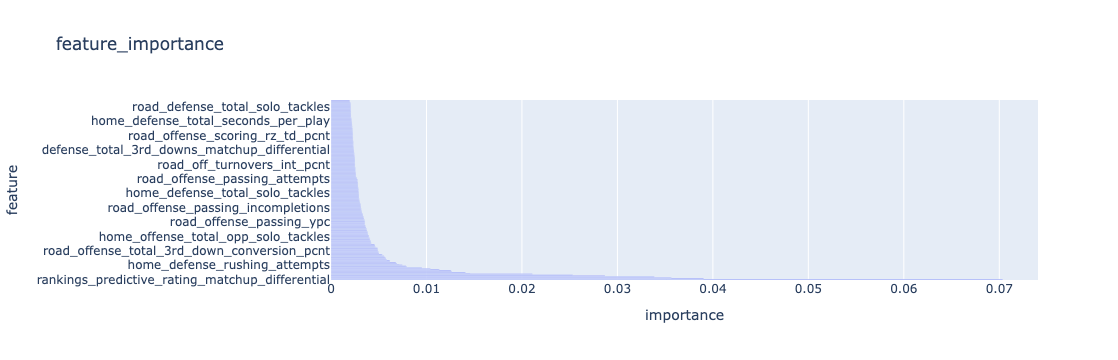

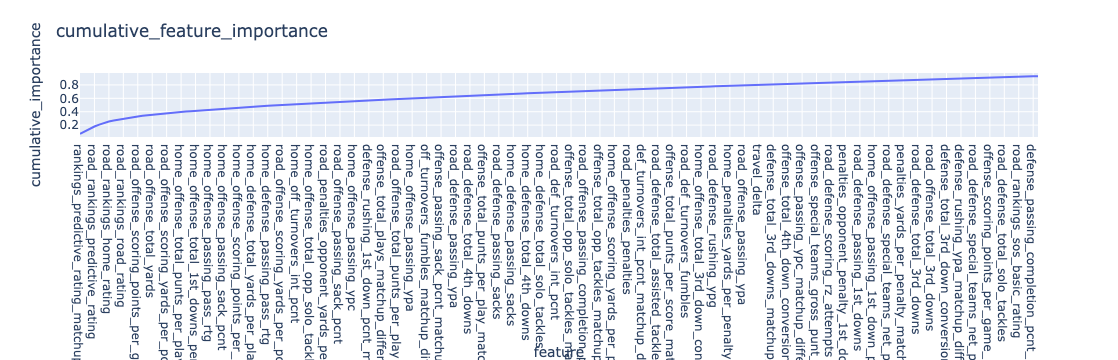

In [39]:
best_features = feature_importance_df.head(200)
best_features["cumulative_importance"] = best_features["importance"].cumsum()
fig = px.bar(best_features, x="importance", y="feature", title="feature_importance")
fig.show()
fig.write_html("../output/visualizations/feature_importance/feature_importance_v2.html")
fig = px.line(best_features, x="feature", y="cumulative_importance", title="cumulative_feature_importance")
fig.show()
fig.write_html("../output/visualizations/feature_importance/cumulative_feature_importance_v2.html")

In [43]:
feature_importance_df["cumulative_importance"] = feature_importance_df["importance"].cumsum()
feature_importance_df.to_csv("../output/feature_importance.csv")